In [1]:
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#https://github.com/TianhongDai/integrated-gradient-pytorch


class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std


norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
weights = ResNet50_Weights.DEFAULT


model = nn.Sequential(
    norm_layer,
    resnet50(weights=weights))


model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

model = model.eval()

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0, 0, 0], std=[255.0, 255.0, 255.0]),
])

#process = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
img = read_image('images/black_swan.jpeg')
#img = read_image('images/macaw.jpg')
batch = transform(img.float()).unsqueeze(0)


In [3]:
batch = batch.to(device)
#preprocess = weights.transforms()
prediction = model(batch).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")
print("Top-K labels:",prediction.topk(5)[1].cpu().numpy())


black swan: 47.5%
Top-K labels: [100 146  99  22  80]


In [4]:
import torch.nn.functional as F


def pre_processing(obs):
    #obs_tensor = process(torch.tensor(obs,requires_grad=True)).to(device)
    obs_tensor = torch.tensor(obs,requires_grad=True).to(device)
    obs_tensor = obs_tensor.clone().detach().requires_grad_(True)  
    return obs_tensor


def calculate_outputs_and_gradients(inputs, model, target_label_idx, cuda=True):
    # do the pre-processing
    predict_idx = None
    gradients = []
    for input in inputs:
        input = pre_processing(input)
        #print(input,input.shape)
        if input.dim() == 4:
            output = model(input.float())
        else:
            output = model(input.float().unsqueeze(0))
        output = F.softmax(output, dim=1)
        #print(output,output.shape)
        if target_label_idx is None:
            target_label_idx = torch.argmax(output, 1).item()
        index = np.ones((output.size()[0], 1)) * target_label_idx
        index = torch.tensor(index, dtype=torch.int64)
        if cuda:
            index = index.cuda()
        output = output.gather(1, index)
        # clear grad
        model.zero_grad()
        output.backward()
        gradient = input.grad.detach().cpu().numpy()[0]
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, target_label_idx


def integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, baseline, steps=50, cuda=True):
    if baseline is None:
        baseline = 0 * inputs 
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads, _ = predict_and_gradients(scaled_inputs, model, target_label_idx, cuda)
    avg_grads = np.average(grads[:-1], axis=0)
    delta_X = (pre_processing(inputs) - pre_processing(baseline)).detach().squeeze(0).cpu().numpy()
    integrated_grad = delta_X * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, steps, num_random_trials, cuda=True):
    all_intgrads = []
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, \
                                                baseline=(np.random.random(inputs.shape)), steps=steps, cuda=cuda)
        all_intgrads.append(integrated_grad)
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads


#batchImg = (batch/255.0).cpu().numpy()

batchImg = batch.cpu().numpy()



gradients, label_index = calculate_outputs_and_gradients(batchImg, model, None)
attributions = random_baseline_integrated_gradients(batchImg, model, label_index, calculate_outputs_and_gradients,steps=50, num_random_trials=10)




In [5]:
G = [0, 255, 0]
R = [255, 0, 0]

def convert_to_gray_scale(attributions):
    return np.average(attributions, axis=2)

def linear_transform(attributions, clip_above_percentile=99.9, clip_below_percentile=70.0, low=0.2, plot_distribution=False):
    m = compute_threshold_by_top_percentage(attributions, percentage=100-clip_above_percentile, plot_distribution=plot_distribution)
    e = compute_threshold_by_top_percentage(attributions, percentage=100-clip_below_percentile, plot_distribution=plot_distribution)
    transformed = (1 - low) * (np.abs(attributions) - e) / (m - e) + low
    transformed *= np.sign(attributions)
    transformed *= (transformed >= low)
    transformed = np.clip(transformed, 0.0, 1.0)
    return transformed

def compute_threshold_by_top_percentage(attributions, percentage=60, plot_distribution=True):
    if percentage < 0 or percentage > 100:
        raise ValueError('percentage must be in [0, 100]')
    if percentage == 100:
        return np.min(attributions)
    flat_attributions = attributions.flatten()
    attribution_sum = np.sum(flat_attributions)
    sorted_attributions = np.sort(np.abs(flat_attributions))[::-1]
    cum_sum = 100.0 * np.cumsum(sorted_attributions) / attribution_sum
    threshold_idx = np.where(cum_sum >= percentage)[0][0]
    threshold = sorted_attributions[threshold_idx]
    if plot_distribution:
        raise NotImplementedError 
    return threshold

def polarity_function(attributions, polarity):
    if polarity == 'positive':
        return np.clip(attributions, 0, 1)
    elif polarity == 'negative':
        return np.clip(attributions, -1, 0)
    else:
        raise NotImplementedError

def overlay_function(attributions, image):
    return np.clip(0.7 * image + 0.5 * attributions, 0, 255)

def visualize(attributions, image, positive_channel=G, negative_channel=R, polarity='positive', \
                clip_above_percentile=99.9, clip_below_percentile=0, morphological_cleanup=False, \
                structure=np.ones((3, 3)), outlines=False, outlines_component_percentage=90, overlay=True, \
                mask_mode=False, plot_distribution=False):
    if polarity == 'both':
        raise NotImplementedError

    elif polarity == 'positive':
        attributions = polarity_function(attributions, polarity=polarity)
        channel = positive_channel
    
    # convert the attributions to the gray scale
    attributions = convert_to_gray_scale(attributions)
    attributions = linear_transform(attributions, clip_above_percentile, clip_below_percentile, 0.0, plot_distribution=plot_distribution)
    attributions_mask = attributions.copy()
    if morphological_cleanup:
        raise NotImplementedError
    if outlines:
        raise NotImplementedError
    attributions = np.expand_dims(attributions, 2) * channel
    if overlay:
        if mask_mode == False:
            attributions = overlay_function(attributions, image)
        else:
            attributions = np.expand_dims(attributions_mask, 2)
            attributions = np.clip(attributions * image, 0, 255)
            attributions = attributions[:, :, (2, 1, 0)]
    return attributions


img_integrated_gradient = visualize(np.transpose(attributions,(1,2,0)), np.transpose(batchImg[0],(1,2,0)), clip_above_percentile=95.0, clip_below_percentile=0, overlay=False)
img_integrated_gradient = img_integrated_gradient/np.max(img_integrated_gradient)


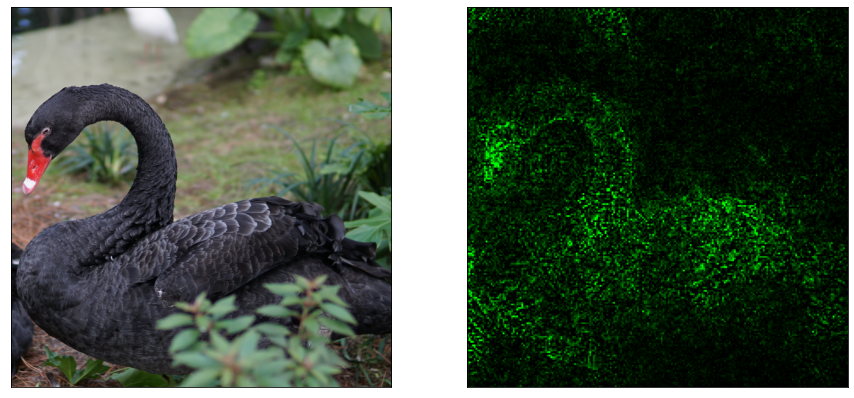

In [7]:
img_intG = torch.tensor(img_integrated_gradient).permute(2, 0, 1)
show([img,img_intG])